# JCOIN Tracking Opioid Stigma
- JCOIN consortium - MAARC Survey Core - Survey Project 1 of 4
- Cross-sectional Repeated Brief Survey tracking stigma related to OUD
- **Significance:** Stigma related to OUD and public attitudes towards persons with OUD and treatment of/for persons with OUD may impact/modify the effect of OUD interventions.

### Import modules

In [2]:
import os
import pandas as pd
import numpy as np
import pyreadstat
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

pd.set_option('mode.chained_assignment', None)

### Import data
- 4 survey time-points in 2020; Feb, Apr, Jun, Oct
- roughly 1000 respondents per survey time-point
- 1st survey time-point before COVID, all other survey time-points after COVID

In [6]:
# list the exported manifests inside data folder
HEAL_FOLDER = "/home/jovyan/pd/data/healdata.org"
sorted(Path(HEAL_FOLDER).iterdir(), key=os.path.getmtime)

[PosixPath('/home/jovyan/pd/data/healdata.org/manifest-2021-08-03T18-21-42.136007')]

In [11]:
#define directory where the files are located
manifest_dir = sorted(Path(HEAL_FOLDER).iterdir(), key=os.path.getmtime)[0]
file_dir = f"{manifest_dir}/by-filename"

In [12]:
# Change directory to the file folder
os.chdir(file_dir)

In [13]:
# Read data using pyreadstat library
df1, meta1 = pyreadstat.read_sav('./JCOIN_NORC_Omnibus_SURVEY1_Feb2020.sav',apply_value_formats=True)
df2, meta2 = pyreadstat.read_sav('./JCOIN_NORC_Omnibus_SURVEY2_April2020.sav',apply_value_formats=True)
df3, meta3 = pyreadstat.read_sav('./JCOIN_NORC_Omnibus_SURVEY3_June2020.sav',apply_value_formats=True)
df4, meta4 = pyreadstat.read_sav('./JCOIN_NORC_Omnibus_SURVEY4_Oct2020.sav',apply_value_formats=True)

### Clean data
- column names to lowercase
- get long, combined dataset; keep only variables available for each survey time-point
- take a look at the data dictionary to check meaning of variable names and identify interesting variables that will let us look at stigma trajectory over time

In [14]:
# standardize column names across datasets and metadatasets

for df in [df1, df2, df3, df4]:
    df.columns = df.columns.str.lower()
    
    
for meta in [meta1, meta2, meta3, meta4]:
    meta.column_names = [x.lower() for x in meta.column_names]
    meta.column_names_to_labels =  {k.lower(): v for k, v in meta.column_names_to_labels.items()}
    meta.variable_value_labels =  {k.lower(): v for k, v in meta.variable_value_labels.items()}

In [15]:
# combine data from all surveys into one long dataset, keeping only vars available across all survey datasets
all_df = pd.concat([df1, df2, df3, df4], keys=['s1','s2','s3','s4'], join="inner").reset_index().rename(columns={"level_0": "time-point"})

# when displaying the data, don't print geo information
all_df.drop(['level_1','region4','region9'],axis=1).head()

,time-point,caseid,weight,personaluse_ever,personalconviction_ever,personalincarceration_ever,familyuse_ever,familyconviction_ever,familyincarceration_ever,surv_mode,...,ss_b_historymarry,ss_c_currentwork,ss_d_currentmarry,incomedummy_less25k,incomedummy_25to49k,incomedummy_50to84k,incomedummy_85to150k,incomedummy_over150k,personalcrimjust_ever,familycrimjust_ever
0,s1,51.0,0.588443,No,No,No,Yes,No,No,Web Interview,...,3,1,1,0.0,0.0,0.0,1.0,0.0,0,0
1,s1,59.0,0.211109,No,No,Yes,No,Yes,Yes,Web Interview,...,3.40792,1.39626,1.40004,1.0,0.0,0.0,0.0,0.0,1,1
2,s1,61.0,0.689192,No,Yes,No,No,Yes,Yes,Web Interview,...,5,2,3,0.0,0.0,0.0,0.0,1.0,1,1
3,s1,63.0,0.908658,Yes,Yes,Yes,Yes,Yes,Yes,Web Interview,...,5,1.39626,1.40004,0.0,0.0,0.0,1.0,0.0,1,1
4,s1,65.0,0.413077,No,No,No,Yes,No,No,Web Interview,...,1.34359,1.39626,1.40004,0.0,0.0,0.0,1.0,0.0,0,0


In [16]:
# print out data dictionary for vars available across all survey datasets
data_dictionary = {k: v for k, v in meta1.column_names_to_labels.items() if k in all_df.columns}
data_dictionary

# print out just data labels for vars available across all survey datasets
#[v for k, v in meta1.column_names_to_labels.items() if k in all_df.columns]

{'caseid': 'Case ID',
 'weight': 'Post-stratification weights - 18+ general population (N=1,036)',
 'personaluse_ever': '[Have you ever used opioids/prescription pain medication illicitly obtained or used in a way not prescribed by a doctor?] The next set of questions are about your own personal experiences or the experiences of any family members or close friends.',
 'personalconviction_ever': '[Have you ever been convicted of any misdemeanor or felony crime?] The next set of questions are about your own personal experiences or the experiences of any family members or close friends.',
 'personalincarceration_ever': '[Have you ever been incarcerated in jail or prison?] The next set of questions are about your own personal experiences or the experiences of any family members or close friends.',
 'familyuse_ever': '[Have any family members or close friends you know ever used opioids/prescription pain medication illicitly obtained or used in a way not prescribed by a doctor?] The next set

### Get a subset of interesting variables that let us look at stigma trajectory over time
- check for missing
- impute missing stigma scale score values with median per timepoint
- impute missing personaluse_ever status with mode, 'No'

In [17]:
sub_df_1 = all_df[['time-point','weight','stigma_scale_score','age4','region4','personaluse_ever']]
#sub_df_1

In [18]:
# check if missing values
sub_df_1.isnull().sum()

# get all var types
#sub_df_1.info()

# summary of numeric vars (weight and stigma_scale_score)
sub_df_1.describe()

# summary of cat vars (age4, region9, personaluse_ever)
sub_df_1.age4.value_counts(dropna=False)

# summary of cat vars (age4, region9, personaluse_ever)
sub_df_1.region4.value_counts(dropna=False)

# summary of cat vars (age4, region9, personaluse_ever)
sub_df_1.personaluse_ever.value_counts(dropna=False)

# impute missing stigma scale score values as the median score by survey time-point
sub_df_1['stigma_scale_score'].fillna(sub_df_1.groupby('time-point')['stigma_scale_score'].transform('median'),inplace=True)
sub_df_1.isnull().sum()

# replace missing values of personaluse_ever with mode value of 'No'
sub_df_1.personaluse_ever.fillna('No',inplace=True)
sub_df_1.isnull().sum()

#sub_df_1

# print the df with geo info hidden
sub_df_1_print = sub_df_1.copy()
sub_df_1_print['region4'] = sub_df_1_print['region4'].replace(['Midwest','West','Northeast','South'],'hidden')

sub_df_1_print

,time-point,weight,stigma_scale_score,age4,region4,personaluse_ever
0,s1,0.588443,3.807179,60+,hidden,No
1,s1,0.211109,3.864296,60+,hidden,No
2,s1,0.689192,2.166667,45-59,hidden,No
3,s1,0.908658,3.078350,30-44,hidden,Yes
4,s1,0.413077,4.298466,30-44,hidden,No
...,...,...,...,...,...,...
4135,s4,2.565855,3.500000,60+,hidden,No
4136,s4,2.476229,4.333333,45-59,hidden,No
4137,s4,1.976881,3.333333,30-44,hidden,No
4138,s4,0.295253,3.833333,60+,hidden,No


### Unweighted and weighted stigma scale score over time
- full sample; sum of weights normalized to count of individuals
- by personal use status
- by geographic region
- by age group

In [19]:
sub_df_1['w_stigma_scale_score'] = sub_df_1['stigma_scale_score'] * sub_df_1['weight']
stigma_all_df = sub_df_1.groupby('time-point').agg({'weight':['count','sum'],'stigma_scale_score':'mean','w_stigma_scale_score':'mean'})
stigma_all_df.columns = stigma_all_df.columns.to_flat_index().str.join('_').str.rstrip('_')
stigma_all_df

,weight_count,weight_sum,stigma_scale_score_mean,w_stigma_scale_score_mean
time-point,,,,
s1,1036,1036.0,3.396356,3.364520
s2,1002,1002.0,3.366933,3.313419
s3,1007,1007.0,3.343926,3.344985
s4,1095,1095.0,3.378539,3.421549


In [20]:
# sum of weights will not be equal to count of individuals when we look at sub-groups of the full population; 
# will have to formally calculate weighted average


def weighted_mean(x, **kws):
    val, weight = map(np.asarray, zip(*x))
    weighted_mean = (val * weight).sum() / weight.sum()
    return (val * weight).sum() / weight.sum()

sub_df_1["score_and_weight"] = list(zip(sub_df_1.stigma_scale_score, sub_df_1.weight))

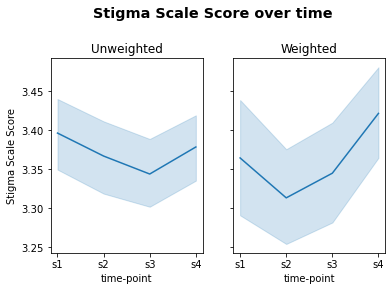

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.suptitle('Stigma Scale Score over time',fontsize='x-large',fontweight='bold')

sns.lineplot(ax = ax1,
             data = sub_df_1,
             x = 'time-point',
             y = 'stigma_scale_score',
             #hue = 'personaluse_ever'
            )

ax1.set_title('Unweighted')
ax1.set(ylabel='Stigma Scale Score')
ax1.invert_yaxis()

sns.lineplot(ax = ax2,
             data = sub_df_1,
             x = 'time-point',
             y = 'score_and_weight',
             estimator = weighted_mean
             #hue = 'personaluse_ever'
            )

ax2.set_title('Weighted')
ax2.invert_yaxis()

plt.subplots_adjust(top=0.80)
plt.show()

### Stigma scale score by personal use ever status

In [22]:
sub_df_1.groupby(['time-point','personaluse_ever']).stigma_scale_score.describe(percentiles=[0.25, 0.5, 0.75])

count      mean       std       min       25%  \
time-point personaluse_ever                                                  
s1         No                934.0  3.432020  0.732115  1.000000  2.987054   
           Yes               102.0  3.069784  0.865137  1.000000  2.480384   
s2         No                927.0  3.396980  0.743600  1.000000  3.000000   
           Yes                75.0  2.995556  0.631965  1.333333  2.666667   
s3         No                912.0  3.367507  0.710348  1.000000  3.000000   
           Yes                95.0  3.117544  0.665723  1.333333  2.833333   
s4         No                997.0  3.411902  0.717802  1.000000  3.000000   
           Yes                98.0  3.039116  0.743741  1.000000  2.666667   

                                  50%       75%       max  
time-point personaluse_ever                                
s1         No                3.452867  3.953567  5.000000  
           Yes               3.117681  3.712692  5.000000  
s2         No                3.333333  3.833333  5.000000  
           Yes               3.000000  3.333333  4.833333  
s3         No                3.333333  3.833333  5.000000  
           Yes               3.000000  3.583333  4.666667  
s4         No                3.333333  3.833333  5.000000  
           Yes               3.000000  3.333333  5.000000

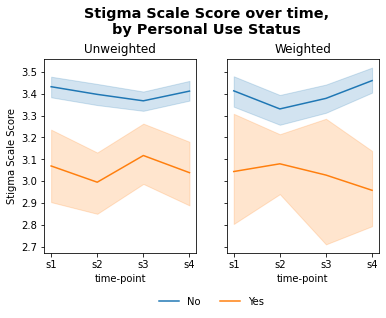

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.suptitle('Stigma Scale Score over time,\nby Personal Use Status',fontsize='x-large',fontweight='bold')

sns.lineplot(ax = ax1,
             data = sub_df_1,
             x = 'time-point',
             y = 'stigma_scale_score',
             hue = 'personaluse_ever'
            )

ax1.set_title('Unweighted')
ax1.set(ylabel='Stigma Scale Score')
ax1.invert_yaxis()

sns.lineplot(ax = ax2,
             data = sub_df_1,
             x = 'time-point',
             y = 'score_and_weight',
             hue = 'personaluse_ever',
             estimator = weighted_mean
            )

ax2.set_title('Weighted')
ax2.invert_yaxis()

legend1 = ax1.legend()
legend1.remove()

legend2 = ax2.legend()
legend2.remove()

leg = ax1.legend(loc='center', bbox_to_anchor=(1.1, -0.25), shadow=False, ncol=2, frameon=False)

plt.subplots_adjust(top=0.80)
plt.show()

### Stigma scale score by geographic region

In [24]:
sub_df_1.groupby(['time-point','region4']).stigma_scale_score.describe(percentiles=[0.25, 0.5, 0.75])

count      mean       std       min       25%       50%  \
time-point region4                                                              
s1         Midwest    295.0  3.414946  0.762161  1.000000  2.973846  3.473846   
           Northeast  170.0  3.397324  0.739814  1.166667  2.861469  3.372820   
           South      310.0  3.411529  0.761053  1.000000  2.980384  3.386845   
           West       261.0  3.356692  0.746543  1.309455  2.936028  3.437897   
s2         Midwest    254.0  3.412730  0.783375  1.000000  3.000000  3.333333   
           Northeast  157.0  3.343949  0.685545  1.000000  3.000000  3.333333   
           South      347.0  3.342939  0.741298  1.000000  3.000000  3.333333   
           West       244.0  3.368169  0.740458  1.000000  3.000000  3.333333   
s3         Midwest    276.0  3.303140  0.693618  1.000000  2.958333  3.333333   
           Northeast  156.0  3.395299  0.774647  1.000000  3.000000  3.333333   
           South      330.0  3.362626  0.707095  1.333333  3.000000  3.333333   
           West       245.0  3.331973  0.689168  1.166667  3.000000  3.333333   
s4         Midwest    274.0  3.447689  0.726484  1.000000  3.000000  3.333333   
           Northeast  168.0  3.367063  0.776090  1.333333  2.958333  3.333333   
           South      383.0  3.399478  0.692018  1.000000  3.000000  3.333333   
           West       270.0  3.285802  0.741261  1.000000  3.000000  3.250000   

                           75%  max  
time-point region4                   
s1         Midwest    3.978982  5.0  
           Northeast  3.973846  5.0  
           South      3.973846  5.0  
           West       3.833333  5.0  
s2         Midwest    4.000000  5.0  
           Northeast  3.833333  5.0  
           South      3.833333  5.0  
           West       3.833333  5.0  
s3         Midwest    3.833333  5.0  
           Northeast  4.000000  5.0  
           South      3.833333  5.0  
           West       3.833333  5.0  
s4         Midwest    3.833333  5.0  
           Northeast  4.000000  5.0  
           South      3.833333  5.0  
           West       3.833333  5.0

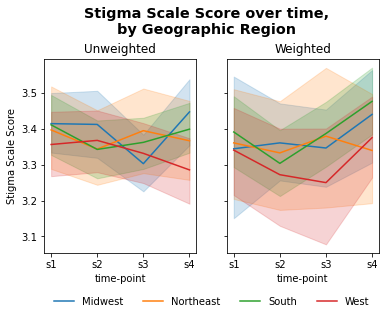

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.suptitle('Stigma Scale Score over time,\nby Geographic Region',fontsize='x-large',fontweight='bold')

sns.lineplot(ax = ax1,
             data = sub_df_1,
             x = 'time-point',
             y = 'stigma_scale_score',
             hue = 'region4'
            )

ax1.set_title('Unweighted')
ax1.set(ylabel='Stigma Scale Score')
ax1.invert_yaxis()

sns.lineplot(ax = ax2,
             data = sub_df_1,
             x = 'time-point',
             y = 'score_and_weight',
             hue = 'region4',
             estimator = weighted_mean
            )

ax2.set_title('Weighted')
ax2.invert_yaxis()


legend1 = ax1.legend()
legend1.remove()

legend2 = ax2.legend()
legend2.remove()

leg = ax1.legend(loc='center', bbox_to_anchor=(1.1, -0.25), shadow=False, ncol=4, frameon=False)
plt.subplots_adjust(top=0.80)
plt.show()

### Stigma scale score by age group

In [26]:
sub_df_1.groupby(['time-point','age4']).stigma_scale_score.describe(percentiles=[0.25, 0.5, 0.75])

count      mean       std       min       25%       50%  \
time-point age4                                                             
s1         18-29   87.0  3.129643  0.827247  1.309455  2.617894  3.307179   
           30-44  283.0  3.295143  0.765354  1.315628  2.789505  3.333333   
           45-59  247.0  3.455095  0.773247  1.000000  3.009541  3.517606   
           60+    419.0  3.485470  0.697480  1.000000  3.050836  3.473846   
s2         18-29  107.0  3.017134  0.594760  1.000000  2.833333  3.000000   
           30-44  309.0  3.285868  0.751918  1.000000  3.000000  3.333333   
           45-59  251.0  3.452191  0.718899  1.000000  3.000000  3.333333   
           60+    335.0  3.489552  0.754102  1.333333  3.000000  3.500000   
s3         18-29  149.0  3.068233  0.649270  1.333333  2.666667  3.000000   
           30-44  356.0  3.256554  0.736403  1.000000  2.833333  3.166667   
           45-59  225.0  3.464444  0.717531  1.666667  3.000000  3.500000   
           60+    277.0  3.506619  0.636592  1.333333  3.166667  3.500000   
s4         18-29  154.0  3.124459  0.643543  1.000000  2.875000  3.000000   
           30-44  345.0  3.313527  0.727823  1.000000  2.833333  3.166667   
           45-59  237.0  3.412799  0.776230  1.000000  3.000000  3.333333   
           60+    359.0  3.527391  0.692768  1.000000  3.166667  3.500000   

                       75%       max  
time-point age4                       
s1         18-29  3.653635  5.000000  
           30-44  3.833333  5.000000  
           45-59  4.008803  5.000000  
           60+    3.984118  5.000000  
s2         18-29  3.333333  4.666667  
           30-44  3.833333  5.000000  
           45-59  3.833333  5.000000  
           60+    4.000000  5.000000  
s3         18-29  3.500000  4.833333  
           30-44  3.666667  5.000000  
           45-59  4.000000  5.000000  
           60+    3.833333  5.000000  
s4         18-29  3.500000  5.000000  
           30-44  3.833333  5.000000  
           45-59  4.000000  5.000000  
           60+    4.000000  5.000000

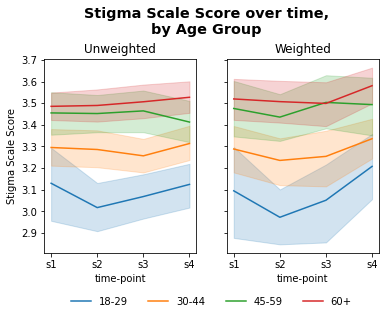

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.suptitle('Stigma Scale Score over time,\nby Age Group',fontsize='x-large',fontweight='bold')

sns.lineplot(ax = ax1,
             data = sub_df_1,
             x = 'time-point',
             y = 'stigma_scale_score',
             hue = 'age4'
            )

ax1.set_title('Unweighted')
ax1.set(ylabel='Stigma Scale Score')
ax1.invert_yaxis()

sns.lineplot(ax = ax2,
             data = sub_df_1,
             x = 'time-point',
             y = 'score_and_weight',
             hue = 'age4',
             estimator = weighted_mean
            )

ax2.set_title('Weighted')
ax2.invert_yaxis()


legend1 = ax1.legend()
legend1.remove()

legend2 = ax2.legend()
legend2.remove()

leg = ax1.legend(loc='center', bbox_to_anchor=(1.1, -0.25), shadow=False, ncol=4, frameon=False)
plt.subplots_adjust(top=0.80)
plt.show()

### Demonstrate how to save plots/tables to file (locally or in workspace for later use)?